In [1]:
# automatically reload solution_augmentation if it is altered and used in the
# notebook
%load_ext autoreload
%autoreload 2

%matplotlib widget


import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy.stats

from lib_augmentation import *

data_path = os.path.expandvars('C:/Users/$USERNAME/Desktop/data/06_data_augmentation/')

path_clean_speech = os.path.join(data_path, 'test/clean/')
path_rirs = os.path.join(data_path, 'test/rir/')

clean_speech, _ = librosa.load(os.path.join(path_clean_speech, 'p227_024.wav'), sr=16E3)
clean_speech -= np.mean(clean_speech)

noise1, _ = librosa.load(os.path.join(data_path, 'test/noise/1-137-A-32.wav'), sr=16E3)
noise2, _ = librosa.load(os.path.join(data_path, 'test/noise/1-17092-A-27.wav'), sr=16E3)
noise = np.concatenate((noise1, noise2))
noise -= np.mean(noise)
noise = noise[:len(clean_speech)]

rir1, _ = librosa.load(os.path.join(path_rirs, '1221.wav'), sr=16E3)
rir2, _ = librosa.load(os.path.join(path_rirs, '1201.wav'), sr=16E3)

## 6.1 Voice Activity Detection

##### Plot Histogram of Log Power

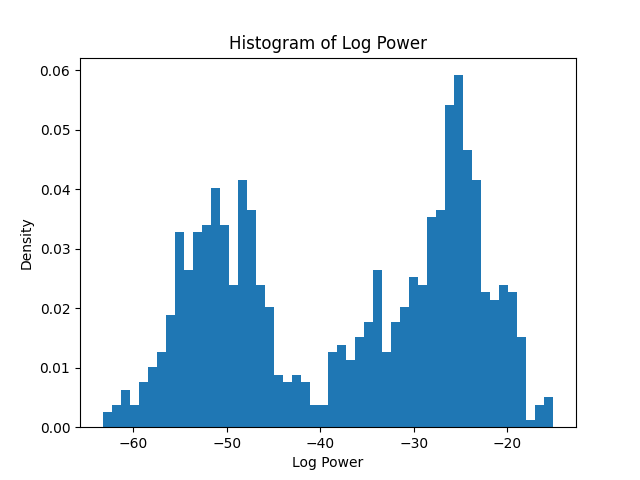

In [2]:
# YOUR CODE HERE
#frame the signal
frame_length = 320
hop_length = 160
frames = librosa.util.frame(clean_speech, frame_length=frame_length, hop_length=hop_length).T

#RMS energy for each frame
rms_power = librosa.feature.rms(y=clean_speech, frame_length=frame_length, hop_length=hop_length)[0]

#log power
log_power = 10 * np.log10(rms_power**2)

#power histogram
plt.hist(log_power, bins=50, density=True)
plt.xlabel('Log Power')
plt.ylabel('Density')
plt.title('Histogram of Log Power')
plt.show()

##### Fit GMM and Show Mean & Variances

In [32]:
# YOUR CODE HERE
from sklearn.mixture import GaussianMixture

#fit a GMM with two components to the speech power
print(log_power.shape)
gmm = GaussianMixture(n_components=2, random_state=0).fit(log_power.reshape(-1, 1))
print("means:\n",gmm.means_)
print("variances:\n",gmm.covariances_)
print("weights:\n",gmm.weights_)

(824,)
means:
 [[-50.73635809]
 [-27.00818101]]
variances:
 [[[22.83532094]]

 [[28.49211501]]]
weights:
 [0.43842192 0.56157808]


##### Plot Gaussians in Histogram

(10,)


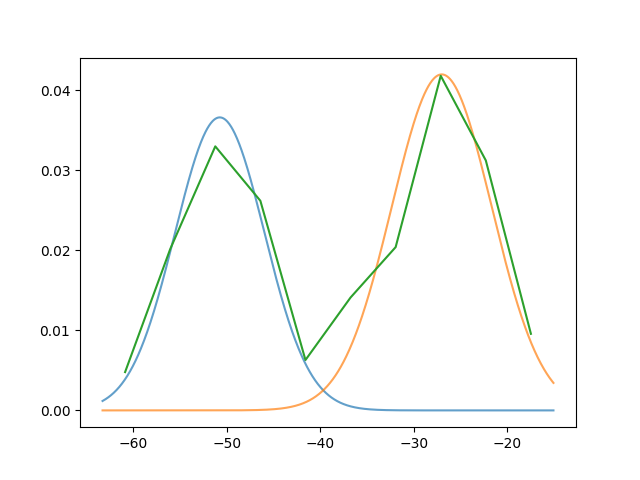

In [44]:
def gaussian(x, m, cov):
    """ Return probability for value(s) *x* of gaussian / normal distribution 
        with mean *m* and standard deviation *cov*
    """
    std = np.sqrt(cov)
    y = np.exp(-((x - m) / std)**2 / 2) / np.sqrt(2*np.pi) / std
    return y

# YOUR CODE HERE
x = np.linspace(log_power.min(), log_power.max(), 1000)

#plt.figure()
#plt.xlabel('Log Power')
#plt.ylabel('Density')
#plt.title('Histogram of GMM')
# Plot the GMM components
plt.figure()
for i in range(2):
    mean = gmm.means_[i, 0]
    covariance = gmm.covariances_[i, 0, 0]
    plt.plot(x,gaussian(x, mean, covariance)*gmm.weights_[i], label=f'Component {i+1}',alpha=0.7)
#axs[1].hist(log_power)
#density = scipy.stats.gaussian_kde(log_power)
#plt.plot(density(x))
hist,bin_edges = np.histogram(log_power,bins=10,density=True)
x2 = np.linspace(log_power.min(), log_power.max(), len(hist))
print(np.shape(hist))
bincenters = (bin_edges[:-1]+bin_edges[1:])/2
plt.plot(bincenters,hist)

In [5]:
# frames containing speech and posterior proba
#identify which cluster corresponds to speech (typically the cluster with higher mean log power)
speech_cluster = np.argmax(gmm.means_)
print("Speech cluster:\n",speech_cluster)

#compute the posterior probabilities for each frame
posterior_probs = gmm.predict_proba(log_power.reshape(-1, 1))[:, speech_cluster]
print("Posterior probabilities:\n",posterior_probs)

Speech cluster:
 1
Posterior probabilities:
 [1.16090548e-06 7.96425789e-07 3.14727855e-06 1.44418661e-06
 2.04956795e-08 1.20079498e-08 3.41503458e-09 9.72307294e-07
 1.47399581e-05 3.16386774e-06 6.19026422e-08 2.24432124e-06
 1.35025591e-06 9.57582659e-08 1.49040669e-07 5.88416026e-07
 3.18109038e-06 1.56710005e-06 2.15773976e-07 2.34010528e-07
 1.39492446e-06 1.40407974e-06 1.96065951e-06 2.80155895e-06
 1.81574523e-06 3.45926141e-06 3.59479251e-05 9.80684265e-05
 1.63403530e-05 7.65416381e-06 6.71640586e-04 3.42605943e-04
 8.61012267e-06 6.85242503e-04 2.54652717e-04 9.03061391e-06
 1.23629968e-05 1.51420978e-05 1.01753019e-05 3.92451042e-05
 1.05683388e-04 1.92032505e-06 3.72709390e-06 1.04614181e-04
 9.09360502e-05 1.01005143e-05 5.13113763e-04 5.74594722e-04
 1.24272314e-06 1.96153507e-07 4.28411947e-07 2.37743047e-07
 2.64455570e-07 1.04480102e-07 1.68013352e-08 1.87864455e-08
 1.26207126e-06 2.81122479e-06 1.64612307e-05 1.95850302e-05
 3.95672351e-07 3.28288229e-08 4.3350221

##### Test Function `vad_extraction`

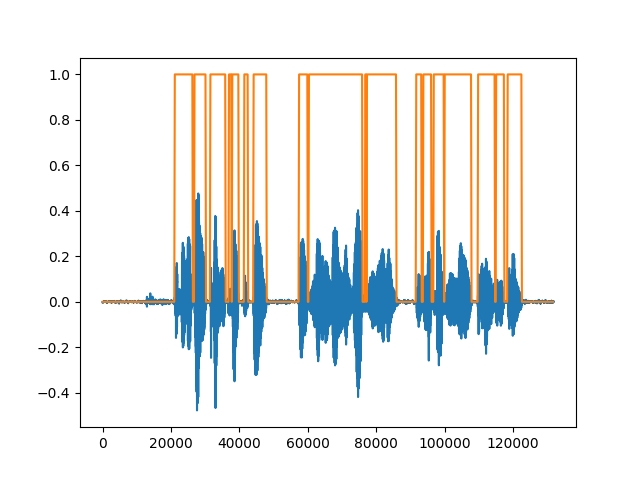

In [6]:
vad = vad_extraction(clean_speech)

_, axis= plt.subplots(1)

axis.plot(clean_speech)

xs = np.arange(len(vad)) * 160
axis.plot(xs, vad * np.max(np.abs(vad)))

## 6.2 Test 'Mix Noise and Speech'

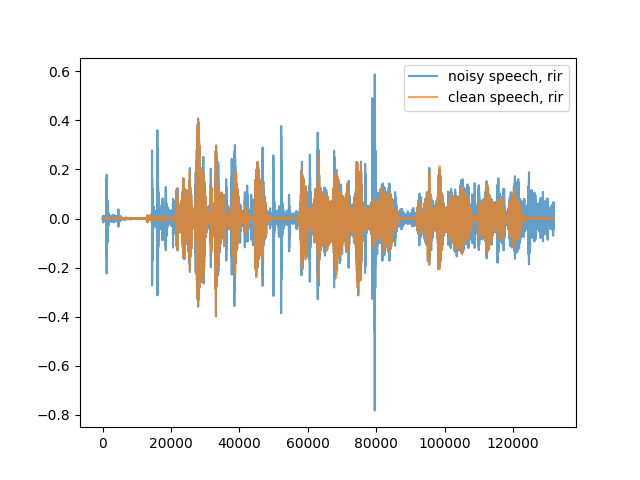

In [7]:
clean_speech_changed, noisy_speech = mix(clean_speech, noise, 5, [rir1, rir2])

_, axis = plt.subplots(1)
axis.plot(noisy_speech, alpha=0.7, label="noisy speech, rir")
axis.plot(clean_speech_changed, alpha=0.7, label="clean speech, rir")
plt.legend()

In [8]:
sr = 16000
sd.play(np.concatenate((clean_speech, noisy_speech)), samplerate=sr)

## 6.3 Test 'Feature Extraction'

In [9]:
features = feature_extraction(noisy_speech)
print(features.shape, '\n\n', features)

(62, 824) 

 [[-6.3165771e+02 -4.8824109e+02 -5.0726202e+02 ... -3.8864789e+02
  -3.9107977e+02 -3.5529568e+02]
 [ 7.5371140e+01  7.1361099e+01  8.6955437e+01 ... -8.4449983e-01
  -7.7743607e+00 -4.8106971e+00]
 [ 1.0003746e+01 -2.1077915e+01 -2.3370209e+01 ... -1.2290958e+01
  -2.5619888e+01 -3.7235477e+01]
 ...
 [ 2.3514854e+03  2.9510940e+03  2.5531853e+03 ...  4.5425596e+03
   4.5186216e+03  4.2114023e+03]
 [ 5.7278320e+03  5.4694336e+03  5.1679688e+03 ...  7.7519531e+03
   7.6658203e+03  6.8044922e+03]
 [ 4.6875000e-02  1.7500000e-01  1.9374999e-01 ...  4.1249999e-01
   3.8437501e-01  2.9374999e-01]]


## 6.4 Test 'Generators'

6152


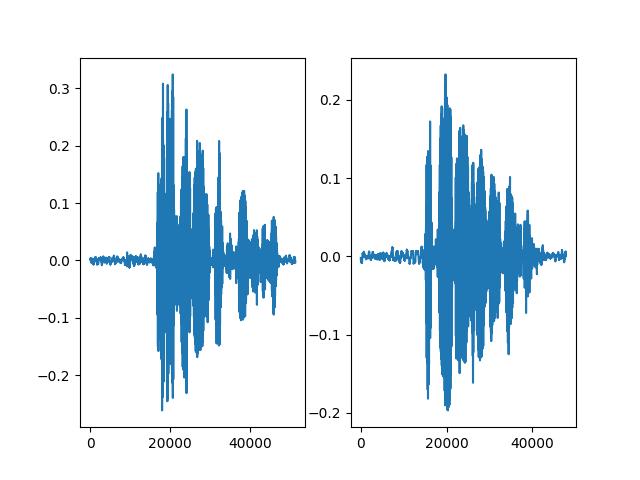

In [45]:
# test init, i.e. creating generator
gen_speech = GenSpeech(path_clean_speech)

# test __next__() two times
clean_speech_1 = next(gen_speech)
clean_speech_2 = next(gen_speech)

# plot retrieved example speech files
_, axes = plt.subplots(1,2)
axes[0].plot(clean_speech_1, label="speech 1")
axes[1].plot(clean_speech_2, label="speech 2")

# test __len__()
print(len(gen_speech))

# test if the generator runs until completion & stops
for speech in gen_speech:
    pass

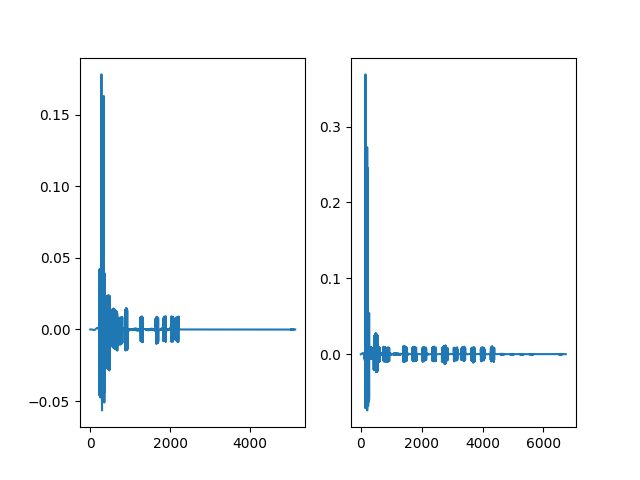

In [11]:
# test init, i.e. creating generator
gen_rirs = create_gen_rir(path_rirs)

# test __next__() two times
rir1 = next(gen_rirs)
rir2 = next(gen_rirs)

# plot retrieved example rirs
_, axes = plt.subplots(1,2)
axes[0].plot(rir1)
axes[1].plot(rir2)

## 6.5 Run Augmentation

In [62]:
for split in ['train', 'val', 'test']:
    path = os.path.join(data_path, split)
    run_augmentation(path, debug=False)

100%|██████████| 6154/6154 [02:24<00:00, 42.51it/s]
